In [2]:
import pickle as pk
path = '/home/thaddaus/MasterthesisCode/'
coco_eval = pk.load(open(path + 'coco_eval.pkl', 'rb'))
coco_evalImgs = pk.load(open(path + 'coco_evalImgs.pkl', 'rb'))
coco_paramsEval = pk.load(open(path + 'coco_paramsEval.pkl', 'rb'))

In [112]:
import numpy as np
p = coco_paramsEval
iou = 0.5 # only consider detections at this IoU
assert iou in p.iouThrs, 'the dataset was not evaluated for IoU 0.5 which is used to calculate the LAMR'
niou = np.where(p.iouThrs==iou)[0][0]
# construct list with FPPI thresholds which will be the x-values of the mr@FPPI curve
# we want even points over the whole log-space and additionally exactly the sample
# points used to calculate the LAMR
evenThrs = np.logspace(-4, 2, num=100)
lamrThrs = np.logspace(-2, 1, num=9)
fppiThrs = np.concatenate((evenThrs, lamrThrs))
fppiThrs = np.unique(fppiThrs)
ilamrThrs = np.searchsorted(fppiThrs, lamrThrs)
p.catIds = p.catIds if p.useCats == 1 else [-1]
N           = len(p.imgIds)
F           = len(fppiThrs) # number of datapoints in mr@FPPI curve
K           = len(p.catIds) if p.useCats else 1
A           = len(p.areaRng)
M           = len(p.maxDets)
mr          = -np.ones((F,K,A,M))
fppi        = -np.ones((K,A,M))
scores      = -np.ones((F,K,A,M))
# confThrs = np.linspace(0, 1, num=C) # detection confidence thresholds
# fppiThrs = np.logspace(1e-4, 10, num=F) # FPPI thresholds
# get inds to evaluate
k_list = [n for n, k in enumerate(p.catIds)]
m_list = [m for n, m in enumerate(p.maxDets)]
a_list = [n for n, a in enumerate(map(lambda x: tuple(x), p.areaRng))]
i_list = [n for n, i in enumerate(p.imgIds)]

In [139]:
# evaluate for each category, area range, and max number of detections
for k, k0 in enumerate(k_list):
    Nk = k0*A*N
    for a, a0 in enumerate(a_list):
        Na = a0*N
        for m, maxDet in enumerate(m_list):
            # get evaluation from all images
            E = [coco_evalImgs[Nk + Na + i] for i in i_list]
            E = [e for e in E if not e is None]
            if len(E) == 0:
                continue

            # get and sort detection scores. use mergesort to be consistent
            # with recall-precision-curve implementation in pycocotools
            dtScores = np.concatenate([e['dtScores'][0:maxDet] for e in E])
            inds = np.argsort(-dtScores, kind='mergesort')
            dtScoresSorted = dtScores[inds]

            # get detection results only for IoU
            dtm  = np.concatenate([e['dtMatches'][niou,0:maxDet] for e in E])[inds]
            dtIg = np.concatenate([e['dtIgnore'][niou,0:maxDet]  for e in E])[inds]
            gtIg = np.concatenate([e['gtIgnore'] for e in E])
            npig = np.count_nonzero(gtIg==0) # number of active ground truths
            if npig == 0:
                continue # skip if no active ground truths

            # calculate metrics
            tps = np.logical_and(               dtm,  np.logical_not(dtIg))
            fps = np.logical_and(np.logical_not(dtm), np.logical_not(dtIg))
            # cumsum yields true and false positives as a function of
            # detection confidence, since the detections are ordered by confidence
            tp_sum = np.cumsum(tps).astype(dtype=float)
            fp_sum = np.cumsum(fps).astype(dtype=float)
            tp    = np.array(tp_sum)
            fp    = np.array(fp_sum)
            nd    = len(fp)
            _mr   = 1 - tp / (npig+np.spacing(1)) # avoid 0-division
            _fppi = fp / N
            q     = np.zeros((F,))
            ss    = np.zeros((F,))
            
            # save overall ffpi
            if nd:
                fppi[k,a,m] = _fppi[-1]
            else:
                fppi[k,a,m] = 0
            
            # numpy is slow without cython optimization for accessing elements
            # use python array gets significant speed improvement
            _mr = _mr.tolist()
            q = q.tolist()

            # remove dips in miss-rate curve
            # for i in range(nd-1, 0, -1):
            #     if _mr[i] > _mr[i-1]:
            #         _mr[i-1] = _mr[i]

            # distribute scores and miss-rate data points over desired fppi range to 
            # construct plot
            inds = np.searchsorted(_fppi, fppiThrs, side='left')
            try:
                for fi, mi in enumerate(inds):
                    q[fi] = _mr[mi]
                    ss[fi] = dtScoresSorted[mi]
            except:
                pass
            mr[:,k,a,m] = np.array(q)
            scores[:,k,a,m] = np.array(ss)


miss_rate = np.mean(mr, axis=1)[:,0,0]
miss_rate[miss_rate==0] = np.nan
confidence = np.mean(scores, axis=1)[:,0,0]
confidence[confidence==0] = np.nan

lamr_samples = miss_rate[ilamrThrs]
min_reached = np.nanmin(lamr_samples)
np.nan_to_num(lamr_samples, copy=False, nan=min_reached)
lamr = np.mean(lamr_samples)

LAMR:  0.4398467432950192


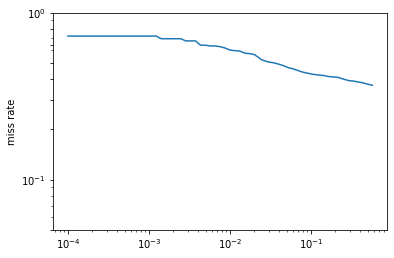

In [145]:
import matplotlib.pyplot as plt
plt.loglog(fppiThrs, miss_rate)
plt.ylim([0.05, 1])
plt.ylabel('miss rate')
plt.yticks([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.64, 0.8, 1.])
print('LAMR: ', lamr)

In [148]:
np.stack((fppiThrs, miss_rate, confidence), axis=1)

array([[1.00000000e-04, 7.23275862e-01, 9.70290303e-01],
       [1.14975700e-04, 7.23275862e-01, 9.70290303e-01],
       [1.32194115e-04, 7.23275862e-01, 9.70290303e-01],
       [1.51991108e-04, 7.23275862e-01, 9.70290303e-01],
       [1.74752840e-04, 7.23275862e-01, 9.70290303e-01],
       [2.00923300e-04, 7.23275862e-01, 9.70290303e-01],
       [2.31012970e-04, 7.23275862e-01, 9.70290303e-01],
       [2.65608778e-04, 7.23275862e-01, 9.70290303e-01],
       [3.05385551e-04, 7.23275862e-01, 9.70290303e-01],
       [3.51119173e-04, 7.23275862e-01, 9.70290303e-01],
       [4.03701726e-04, 7.23275862e-01, 9.70290303e-01],
       [4.64158883e-04, 7.23275862e-01, 9.70290303e-01],
       [5.33669923e-04, 7.23275862e-01, 9.70290303e-01],
       [6.13590727e-04, 7.23275862e-01, 9.70290303e-01],
       [7.05480231e-04, 7.23275862e-01, 9.70290303e-01],
       [8.11130831e-04, 7.23275862e-01, 9.70290303e-01],
       [9.32603347e-04, 7.23275862e-01, 9.70290303e-01],
       [1.07226722e-03, 7.23275